# The Continuous Thought Machine – Tutorial: MNIST

Современные модели глубокого обучения игнорируют время как ключевой вычислительный элемент. В отличие от них, **Машина Непрерывного Мышления (Continuous Thought Machine, CTM)** использует внутреннюю рекуррентность и нейронную синхронизацию, чтобы моделировать *мышление как временной процесс*.  

### Основные идеи  

- **Внутренние такты**: CTM работает на собственной временной оси (независимой от входных данных), которую мы рассматриваем как измерение, в котором разворачивается мышление.  
- **Модели на уровне нейронов**: Каждый нейрон имеет собственную MLP (многослойную нейросеть), обрабатывающую свою историю пред-активаций во времени.  
- **Синхронизация как представление**: CTM вычисляет синхронизацию между нейронами во времени и использует эти сигналы для механизмов внимания и вывода.  

### Почему это важно  

- Позволяет проводить **интерпретируемое, динамическое рассуждение**.  
- Поддерживает **адаптивные вычисления** (например, больше тактов для сложных задач).  
- Работает в разных задачах: классификация, логические рассуждения, память, обучение с подкреплением — *без изменения базовых механизмов*.

### Классификация MNIST  

В этом руководстве мы разберём простой пример: обучение **Машины Непрерывного Мышления (CTM)** для классификации цифр из датасета MNIST. Мы рассмотрим:  

- **Определение модели**  
- **Построение функции потерь**  
- **Обучение**  
- **Визуализация процесса**

Imports

In [1]:
!pip install mediapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.5 MB/s eta 0:00:00


In [2]:
"""
Демонстрация реализации Continuous Thought Machine (CTM).

Эта тетрадка содержит:
1.  Реализацию модели Continuous Thought Machine (CTM) на PyTorch.
2.  Вспомогательные классы и функции для модели CTM.
3.  Функции для обучения и оценки модели на наборе данных MNIST.
4.  Функцию для генерации GIF-анимации, визуализирующей внутренние
    процессы CTM во время предсказания.

Функциональное назначение:
---------------------------
Код предназначен для демонстрации архитектуры CTM, описанной в
сопутствующем техническом обзоре. Он показывает, как CTM обрабатывает
входные данные, используя внутренние итерации ("тики мысли"),
нейронные модели уровня нейрона (NLM), историю активаций и механизм
синхронизации для формирования предсказаний.
Основной пример использования - обучение CTM на задаче классификации
изображений MNIST и визуализация ее работы.
"""

# Стандартные библиотеки
import math
from typing import List, Tuple, Dict, Any, Optional, Union

# Сторонние библиотеки
import imageio
import matplotlib.pyplot as plt
import mediapy
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.special import softmax
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

# Константы для моделирования и обучения
# Параметры для CTM по умолчанию
DEFAULT_ITERATIONS: int = 30
DEFAULT_D_MODEL: int = 128
DEFAULT_D_INPUT: int = 32
DEFAULT_MEMORY_LENGTH: int = 15
DEFAULT_HEADS: int = 1
DEFAULT_N_SYNCH_OUT: int = 16
DEFAULT_N_SYNCH_ACTION: int = 16
DEFAULT_MEMORY_HIDDEN_DIMS: int = 8
DEFAULT_OUT_DIMS_MNIST: int = 10

# Параметры для данных MNIST
MNIST_BATCH_SIZE: int = 64
MNIST_NUM_WORKERS: int = 1

# Параметры обучения
TRAIN_ITERATIONS: int = 2000
LEARNING_RATE: float = 0.0001
ADAMW_EPS: float = 1e-8
TEST_EVERY_N_STEPS: int = 100

# Параметры для CTM
MAX_DECAY_PARAM_CLAMP: float = 15.0  # Максимальное значение для параметров затухания

# Параметры для визуализации GIF
GIF_FIG_SCALE: float = 0.28
GIF_N_NEURONS_TO_VISUALISE: int = 16
GIF_FPS: int = 5
GIF_LOOP_COUNT: int = 100
# Цвета для GIF
COLOR_TARGET_CORRECT: str = 'g'
COLOR_TARGET_INCORRECT: str = 'b'
COLOR_CERTAINTY_LINE: str = 'k-'
COLOR_PRE_ACTIVATION_LINE: str = 'grey'
COLOR_POST_ACTIVATION_EVEN: str = 'blue'
COLOR_POST_ACTIVATION_ODD: str = 'red'
COLOR_VERTICAL_LINE: str = 'black'

### Начинаем с определения вспомогательных классов, которые понадобятся для реализации CTM.

Особого внимания заслуживает класс **SuperLinear**, который реализует **N уникальных линейных преобразований**. Этот класс будет использоваться для моделей на уровне отдельных нейронов.

In [3]:
# Вспомогательный модуль: тождественное отображение
class Identity(nn.Module):
    """
    Description:
    ---------------
        Модуль, выполняющий тождественное отображение входа на выход.

    Args:
    ---------------
        Нет.

    Returns:
    ---------------
        Объект модуля Identity.

    Examples:
    ---------------
        >>> id_module = Identity()
        >>> x = torch.randn(2, 3)
        >>> y = id_module(x)
        >>> torch.equal(x, y)
        True
    """
    def __init__(self) -> None:
        super().__init__()

    # Прямой проход модуля
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Description:
        ---------------
            Возвращает входной тензор без изменений.

        Args:
        ---------------
            x: Входной тензор.

        Returns:
        ---------------
            Тот же входной тензор.
        """
        return x


# Вспомогательный модуль: удаление измерения
class Squeeze(nn.Module):
    """
    Description:
    ---------------
        Модуль, удаляющий указанное измерение из тензора.

    Args:
    ---------------
        dim: Индекс измерения для удаления.

    Returns:
    ---------------
        Объект модуля Squeeze.

    Examples:
    ---------------
        >>> squeeze_module = Squeeze(dim=1)
        >>> x = torch.randn(2, 1, 3)
        >>> y = squeeze_module(x)
        >>> y.shape
        torch.Size([2, 3])
    """
    def __init__(self, dim: int) -> None:
        super().__init__()
        self.dim: int = dim

    # Прямой проход модуля
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Description:
        ---------------
            Удаляет указанное измерение из входного тензора.

        Args:
        ---------------
            x: Входной тензор.

        Returns:
        ---------------
            Тензор с удаленным измерением.
        """
        return x.squeeze(self.dim)


# Реализует модели уровня нейрона (NLM) для CTM
class SuperLinear(nn.Module):
    """
    Description:
    ---------------
        Слой SuperLinear, реализующий модели уровня нейрона (NLM) для CTM.
        Каждый из N нейронов имеет свои собственные веса для обработки
        входной последовательности (истории пре-активаций).

    Args:
    ---------------
        in_dims: Размерность входной истории для каждого нейрона (M).
        out_dims: Размерность выхода для каждого нейрона.
        N: Количество независимых нейронных моделей (d_model).

    Returns:
    ---------------
        Объект слоя SuperLinear.

    Examples:
    ---------------
        >>> nlm_layer = SuperLinear(in_dims=15, out_dims=1, N=128)
        >>> x = torch.randn(64, 128, 15)  # (B, N, in_dims)
        >>> out = nlm_layer(x)
        >>> out.shape
        torch.Size([64, 128])
    """
    def __init__(self, in_dims: int, out_dims: int, N: int) -> None:
        super().__init__()
        self.in_dims: int = in_dims
        # Инициализация весов и смещений для NLM
        # w1: веса для каждого из N нейронов, форма (M, H_out, N)
        # b1: смещения для каждого из N нейронов, форма (1, N, H_out)
        # Инициализация выполнена так, чтобы значения были небольшими,
        # способствуя стабильности обучения.
        self.register_parameter(
            'w1',
            nn.Parameter(
                torch.empty(
                    (in_dims, out_dims, N)
                ).uniform_(
                    -1 / math.sqrt(in_dims + out_dims),
                    1 / math.sqrt(in_dims + out_dims)
                ), requires_grad=True
            )
        )
        self.register_parameter(
            'b1',
            nn.Parameter(torch.zeros((1, N, out_dims)), requires_grad=True)
        )

    # Прямой проход слоя SuperLinear
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Description:
        ---------------
            Выполняет прямое распространение через слой SuperLinear.
            Применяет уникальные линейные преобразования к истории каждого
            нейрона.

        Args:
        ---------------
            x: Входной тензор формы (B, N, M), где B - размер батча,
               N - количество нейронов (d_model), M - длина истории
               (in_dims).

        Returns:
        ---------------
            Выходной тензор формы (B, N), если out_dims=1,
            или (B, N, out_dims) в общем случае, после сжатия
            последнего измерения, если оно равно 1.
        """
        # Эквивалентно батчевому матричному умножению для каждого нейрона
        # x (B, N, M) @ w1 (M, H_out, N) -> (B, N, H_out) (поэлементно)
        # Используется einsum для явного указания операций.
        # 'BDM,MHD->BDH': B-батч, D-нейроны(N), M-история, H-выход(out_dims)
        out: torch.Tensor = torch.einsum(
            'BDM,MHD->BDH', x, self.w1
        ) + self.b1
        # Если выходная размерность равна 1, удаляем это измерение
        out = out.squeeze(-1)
        return out

Далее мы определяем вспомогательную функцию `compute_normalized_entropy`. Эта функция будет использоваться внутри CTM для вычисления уверенности модели на каждом внутреннем такте по формуле:  
**уверенность = 1 - нормированная энтропия**.

In [4]:
# Вычисляет нормализованную энтропию для лосса уверенности
def compute_normalized_entropy(
    logits: torch.Tensor,
    reduction: str = 'mean'
) -> torch.Tensor:
    """
    Description:
    ---------------
        Вычисляет нормализованную энтропию для оценки уверенности модели.
        Нормализация производится относительно максимальной возможной
        энтропии для данного числа классов.

    Args:
    ---------------
        logits: Логиты модели (выходы до softmax) формы (B, C) или
                (B, ..., C), где C - количество классов.
        reduction: Способ агрегации энтропии, если вход многомерный.
                   'mean' - усреднить по всем измерениям, кроме батча и
                   классов.

    Returns:
    ---------------
        Тензор нормализованной энтропии. Если reduction='mean' и вход
        многомерный, то форма (B,). Иначе, форма совпадает с logits
        за исключением последнего измерения.

    Raises:
    ---------------
        Нет явных.

    Examples:
    ---------------
        >>> logits_example = torch.tensor([[1.0, 1.0, 1.0], [2.0, 0.5, 0.5]])
        >>> norm_entropy = compute_normalized_entropy(logits_example)
        >>> norm_entropy.shape
        torch.Size([2])
        >>> round(norm_entropy[0].item(), 2)
        1.0
    """
    preds: torch.Tensor = F.softmax(logits, dim=-1)
    log_preds: torch.Tensor = torch.log_softmax(logits, dim=-1)
    entropy: torch.Tensor = -torch.sum(preds * log_preds, dim=-1)

    num_classes: int = preds.shape[-1]
    # Максимальная энтропия для равномерного распределения
    max_entropy: torch.Tensor = torch.log(
        torch.tensor(num_classes, dtype=torch.float32)
    )
    # Нормализация энтропии к диапазону [0, 1]
    normalized_entropy: torch.Tensor = entropy / max_entropy

    # Если логиты многомерные (например, для каждого шага итерации CTM),
    # усредняем энтропию по этим дополнительным измерениям.
    if len(logits.shape) > 2 and reduction == 'mean':
        normalized_entropy = normalized_entropy.flatten(1).mean(-1)
    return normalized_entropy

## Обзор архитектуры CTM

Модель CTM инициализируется со следующими основными параметрами:

- `iterations`: Количество внутренних тактов (рекуррентных шагов)
- `d_model`: Общее количество нейронов
- `d_input`: Размерность входных данных и эмбеддингов внимания
- `memory_length`: Длина скользящего окна активаций для каждого нейрона
- `heads`: Количество голов механизма внимания
- `n_synch_out`: Количество нейронов для выходной синхронизации
- `n_synch_action`: Количество нейронов для вычисления запросов внимания
- `out_dims`: Размерность выходных данных модели

### Ключевые компоненты

При инициализации CTM создает следующие модули:

- **Backbone**: CNN для извлечения признаков из входных данных (например, изображений)
- **Synapses**: Слой взаимодействия между нейронами
- **Trace Processor**: Нейрон-уровневая модель, обрабатывающая временные последовательности активаций
- **Synchronization Buffers**: Буферы для отслеживания затухания сигналов
- **Learned Initial States**: Начальные состояния активаций и временных последовательностей

---

## Механика прямого прохода

На каждом внутреннем такте `stepi` CTM выполняет следующую процедуру:

1. **Инициализация рекуррентного состояния**:
    - `state_trace`: Временная последовательность для каждого нейрона
    - `activated_state`: Текущие пост-активации
    - `decay_alpha_out`, `decay_beta_out`: Параметры для расчета синхронизации

2. **Извлечение признаков**:
    - Использование CNN backbone для получения key-value пар внимания (`kv`)

3. **Внутренний цикл** (для каждого такта `stepi`):
    1. Вычисление `synchronisation_action` на основе `n_synch_action` нейронов
    2. Генерация запроса внимания `q` из синхронизации
    3. Выполнение multi-head cross-attention над `kv`
    4. Конкатенация выхода внимания с текущими активациями нейронов
    5. Обновление нейронов через synaptic модуль
    6. Добавление новой активации в окно последовательности
    7. Обновление состояний нейронов через `trace_processor`
    8. Вычисление `synchronisation_out` на основе `n_synch_out` нейронов
    9. Проекция в выходное пространство через `output_projector`
    10. Расчет уверенности предсказания через нормированную энтропию

Этот внутренний цикл повторяется заданное количество раз. CTM выдает **предсказания и показатели уверенности на каждом внутреннем такте**.

> Для подробного математического описания механизма синхронизации обратитесь к техническому отчету.

In [ ]:
# Основной класс модели Continuous Thought Machine
class ContinuousThoughtMachine(nn.Module):
    """
    Description:
    ---------------
        Реализация модели Continuous Thought Machine (CTM).
        CTM использует внутренние итерации ("тики мысли"), историю
        активаций и механизм синхронизации для обработки информации.

    Args:
    ---------------
        iterations: Количество внутренних итераций (T).
        d_model: Размерность скрытого состояния нейронов (D).
        d_input: Размерность выхода механизма внимания (o_t).
        memory_length: Длина истории пре-активаций для NLM (M).
        heads: Количество голов во внимании.
        n_synch_out: Количество нейронов, используемых для формирования
                     выходного представления синхронизации.
        n_synch_action: Количество нейронов, используемых для формирования
                        представления синхронизации для запроса внимания.
        out_dims: Размерность выходного слоя (количество классов).
        memory_hidden_dims: Размерность скрытого слоя в NLM.

    Returns:
    ---------------
        Объект модели ContinuousThoughtMachine.

    Raises:
    ---------------
        Нет явных.

    Examples:
    ---------------
        >>> ctm_model = ContinuousThoughtMachine(
        ...     iterations=10, d_model=64, d_input=32, memory_length=5,
        ...     heads=2, n_synch_out=8, n_synch_action=8, out_dims=10,
        ...     memory_hidden_dims=4
        ... )
        >>> ctm_model # doctest: +ELLIPSIS
        ContinuousThoughtMachine(...)
    """
    def __init__(
        self,
        iterations: int,
        d_model: int,
        d_input: int,
        memory_length: int,
        heads: int,
        n_synch_out: int,
        n_synch_action: int,
        out_dims: int,
        memory_hidden_dims: int,
    ) -> None:
        super().__init__()

        # --- Основные параметры модели ---
        self.iterations: int = iterations
        self.d_model: int = d_model
        self.d_input: int = d_input
        self.memory_length: int = memory_length
        self.n_synch_out: int = n_synch_out
        self.n_synch_action: int = n_synch_action
        self.out_dims: int = out_dims
        # self.memory_length дублировался, убрал
        self.memory_hidden_dims: int = memory_hidden_dims

        # --- Обработка входных данных (Feature Extractor & Attention) ---
        # Backbone: извлекает признаки из входных изображений
        self.backbone: nn.Sequential = nn.Sequential(
            nn.LazyConv2d(d_input, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(d_input),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(d_input, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(d_input),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Механизм внимания для взаимодействия с признаками данных
        self.attention: nn.MultiheadAttention = nn.MultiheadAttention(
            self.d_input, heads, batch_first=True
        )
        # Проекторы для ключей (K), значений (V) и запроса (Q) внимания
        self.kv_proj: nn.Sequential = nn.Sequential(
            nn.LazyLinear(self.d_input), nn.LayerNorm(self.d_input)
        )
        self.q_proj: nn.Linear = nn.LazyLinear(self.d_input)

        # --- Основные модули CTM ---
        # Синаптическая модель (f_theta_syn): обрабатывает z_t и o_t
        # для получения пре-активаций a_t
        self.synapses: nn.Sequential = nn.Sequential(
            nn.LazyLinear(d_model * 2),  # Вход: конкатенация z_t и o_t
            nn.GLU(),                    # Gated Linear Unit для нелинейности
            nn.LayerNorm(d_model)        # Нормализация
        )
        # Процессор истории (NLM - Neuron-Level Models): g_theta_d
        # обрабатывает историю пре-активаций A_t_d для получения z_{t+1}_d
        self.trace_processor: nn.Sequential = nn.Sequential(
            SuperLinear(
                in_dims=memory_length,
                out_dims=2 * memory_hidden_dims,
                N=d_model
            ),
            nn.GLU(),
            SuperLinear(
                in_dims=memory_hidden_dims,
                out_dims=2,  # Выход GLU будет memory_hidden_dims / 2 = 1
                N=d_model
            ),
            nn.GLU(),
            Squeeze(-1)      # Удаляет последнее измерение, если оно равно 1
        )

        # --- Начальные состояния ---
        # Обучаемое начальное состояние активаций (z^0)
        self.register_parameter(
            'start_activated_state',
            nn.Parameter(
                torch.zeros((d_model)).uniform_(
                    -math.sqrt(1 / (d_model)),
                    math.sqrt(1 / (d_model))
                ),
                requires_grad=True
            )
        )
        # Обучаемая начальная история пре-активаций (A^0)
        self.register_parameter(
            'start_trace',
            nn.Parameter(
                torch.zeros((d_model, memory_length)).uniform_(
                    -math.sqrt(1 / (d_model + memory_length)),
                    math.sqrt(1 / (d_model + memory_length))
                ),
                requires_grad=True
            )
        )

        # --- Параметры синхронизации ---
        # Размерности векторов синхронизации для действия и выхода
        self.synch_representation_size_action: int = \
            (self.n_synch_action * (self.n_synch_action + 1)) // 2
        self.synch_representation_size_out: int = \
            (self.n_synch_out * (self.n_synch_out + 1)) // 2

        # Отладочный вывод размеров представлений синхронизации
        for synch_type, size in [
            ('action', self.synch_representation_size_action),
            ('out', self.synch_representation_size_out)
        ]:
            print(
                f"Synch representation size {synch_type}: {size}"
            )

        # Инициализация параметров для выходной синхронизации
        self.set_synchronisation_parameters('out', self.n_synch_out)
        # Инициализация параметров для синхронизации действия (внимания)
        self.set_synchronisation_parameters('action', self.n_synch_action)

        # --- Обработка выходных данных ---
        # Проектор для получения финальных предсказаний из синхронизации
        self.output_projector: nn.Sequential = nn.Sequential(
            nn.LazyLinear(self.out_dims)
        )

    # Инициализирует параметры, связанные с синхронизацией
    def set_synchronisation_parameters(
        self,
        synch_type: str,
        n_synch: int
    ) -> None:
        """
        Description:
        ---------------
            Инициализирует буферы с индексами нейронов и обучаемые
            параметры затухания для заданного типа синхронизации.

        Args:
        ---------------
            synch_type: Тип синхронизации ('out' или 'action').
            n_synch: Количество нейронов, участвующих в данном типе
                     синхронизации.

        Returns:
        ---------------
            None.

        Raises:
        ---------------
            ValueError: Если synch_type не 'out' или 'action'.
                        (Не реализовано, но подразумевается).
        """
        left, right = self.initialize_left_right_neurons(
            synch_type, self.d_model, n_synch
        )
        synch_representation_size: int = (
            self.synch_representation_size_action
            if synch_type == 'action'
            else self.synch_representation_size_out
        )
        # Регистрация буферов для индексов (не обучаемые)
        self.register_buffer(
            f'{synch_type}_neuron_indices_left', left
        )
        self.register_buffer(
            f'{synch_type}_neuron_indices_right', right
        )
        # Регистрация обучаемых параметров затухания
        self.register_parameter(
            f'decay_params_{synch_type}',
            nn.Parameter(
                torch.zeros(synch_representation_size), requires_grad=True
            )
        )

    # Инициализирует индексы левых и правых нейронов для синхронизации
    def initialize_left_right_neurons(
        self,
        synch_type: str,
        d_model: int,
        n_synch: int
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Description:
        ---------------
            Определяет, какие нейроны будут использоваться для вычисления
            парной синхронизации. Для 'out' берутся первые n_synch нейронов,
            для 'action' - последние n_synch.

        Args:
        ---------------
            synch_type: Тип синхронизации ('out' или 'action').
            d_model: Общее количество нейронов.
            n_synch: Количество нейронов для синхронизации.

        Returns:
        ---------------
            Кортеж из двух тензоров: индексы "левых" и "правых" нейронов
            для формирования пар.

        Raises:
        ---------------
            ValueError: Если synch_type не 'out' или 'action'.
        """
        if synch_type == 'out':
            # Для выходной синхронизации используются первые n_synch нейронов
            neuron_indices_left: torch.Tensor = torch.arange(0, n_synch)
            neuron_indices_right: torch.Tensor = torch.arange(0, n_synch)
        elif synch_type == 'action':
            # Для синхронизации действия используются последние n_synch нейронов
            neuron_indices_left = torch.arange(d_model - n_synch, d_model)
            neuron_indices_right = torch.arange(d_model - n_synch, d_model)
        else:
            raise ValueError(
                f"Unknown synch_type: {synch_type}. "
                "Must be 'out' or 'action'."
            )
        return neuron_indices_left, neuron_indices_right

    # Вычисляет представление синхронизации
    def compute_synchronisation(
        self,
        activated_state: torch.Tensor,
        decay_alpha: Optional[torch.Tensor],
        decay_beta: Optional[torch.Tensor],
        r_decay: torch.Tensor,
        synch_type: str
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Description:
        ---------------
            Вычисляет матрицу синхронизации S_t = Z_t * Z_t^T с учетом
            экспоненциального затухания для прошлых состояний.
            Использует рекурсивное обновление для alpha и beta.

        Args:
        ---------------
            activated_state: Текущее состояние активаций нейронов (z_t),
                             форма (B, D).
            decay_alpha: Предыдущее значение alpha для рекурсивного обновления.
            decay_beta: Предыдущее значение beta для рекурсивного обновления.
            r_decay: Параметр затухания (exp(-decay_params)).
            synch_type: Тип синхронизации ('out' или 'action').

        Returns:
        ---------------
            Кортеж:
                synchronisation: Вычисленное представление синхронизации.
                decay_alpha: Обновленное значение alpha.
                decay_beta: Обновленное значение beta.
        """
        # Выбор подмножества нейронов в зависимости от типа синхронизации
        if synch_type == 'action':
            n_synch: int = self.n_synch_action
            # Берутся последние n_synch_action нейронов
            selected_neurons: torch.Tensor = activated_state[:, -n_synch:]
        elif synch_type == 'out':
            n_synch = self.n_synch_out
            # Берутся первые n_synch_out нейронов
            selected_neurons = activated_state[:, :n_synch]
        else:
            # Обработка неизвестного типа синхронизации
            raise ValueError(f"Неизвестный тип синхронизации: {synch_type}")

        selected_left: torch.Tensor = selected_neurons
        selected_right: torch.Tensor = selected_neurons

        # Внешнее произведение для получения всех парных произведений z_i * z_j
        # selected_left (B, n_synch) -> (B, n_synch, 1)
        # selected_right (B, n_synch) -> (B, 1, n_synch)
        # outer (B, n_synch, n_synch)
        outer: torch.Tensor = (
            selected_left.unsqueeze(2) * selected_right.unsqueeze(1)
        )
        # Взятие верхнего треугольника матрицы outer, включая диагональ,
        # для получения уникальных пар (i, j) где i <= j.
        i, j = torch.triu_indices(n_synch, n_synch, device=outer.device)
        pairwise_product: torch.Tensor = outer[:, i, j]

        # Рекурсивное обновление alpha и beta
        if decay_alpha is None or decay_beta is None:
            # Инициализация на первом шаге
            decay_alpha = pairwise_product
            decay_beta = torch.ones_like(pairwise_product)
        else:
            # r_decay применяется к предыдущим значениям alpha и beta
            decay_alpha = r_decay * decay_alpha + pairwise_product
            decay_beta = r_decay * decay_beta + 1

        # Вычисление синхронизации с нормализацией
        # sqrt(decay_beta) используется для нормализации,
        # аналогично делению на sqrt(d) в механизме внимания.
        synchronisation: torch.Tensor = decay_alpha / (
            torch.sqrt(decay_beta)
        )
        return synchronisation, decay_alpha, decay_beta

    # Извлекает признаки из входных данных
    def compute_features(self, x: torch.Tensor) -> torch.Tensor:
        """
        Description:
        ---------------
            Обрабатывает входной тензор x (изображения) через backbone
            (ResNet-подобную сверточную сеть) для получения карты признаков.
            Затем проекцией формирует ключи (K) и значения (V) для
            механизма внимания.

        Args:
        ---------------
            x: Входной тензор изображений, форма (B, C_in, H, W).

        Returns:
        ---------------
            Тензор признаков (ключи/значения) для внимания,
            форма (B, NumPatches, d_input).
        """
        # input_features: (B, d_input, H_feat, W_feat)
        input_features: torch.Tensor = self.backbone(x)
        # kv: (B, H_feat * W_feat, d_input)
        # Сначала выравниваем пространственные измерения,
        # затем транспонируем для формата (B, NumPatches, Dim)
        kv: torch.Tensor = self.kv_proj(
            input_features.flatten(2).transpose(1, 2)
        )
        return kv

    # Вычисляет уверенность на основе текущего предсказания
    def compute_certainty(
        self,
        current_prediction: torch.Tensor
    ) -> torch.Tensor:
        """
        Description:
        ---------------
            Вычисляет меру уверенности модели на основе текущих логитов
            предсказания. Уверенность определяется как 1 минус
            нормализованная энтропия.

        Args:
        ---------------
            current_prediction: Логиты текущего предсказания, форма (B, C).

        Returns:
        ---------------
            Тензор уверенности, форма (B, 2), где первый столбец -
            нормализованная энтропия, второй - уверенность (1 - энтропия).
        """
        # ne: (B,) - нормализованная энтропия
        ne: torch.Tensor = compute_normalized_entropy(current_prediction)
        # current_certainty: (B, 2)
        current_certainty: torch.Tensor = torch.stack((ne, 1 - ne), -1)
        return current_certainty

    # Прямой проход модели CTM
    def forward(
        self,
        x: torch.Tensor,
        track: bool = False
    ) -> Union[
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
        Tuple[
            torch.Tensor, torch.Tensor,
            Tuple[np.ndarray, np.ndarray],
            np.ndarray, np.ndarray, np.ndarray
        ]
    ]:
        """
        Description:
        ---------------
            Выполняет полный цикл прямого распространения CTM на
            `self.iterations` внутренних тиков.

        Args:
        ---------------
            x: Входной тензор данных (например, изображения),
               форма (B, C_in, H, W).
            track: Флаг, указывающий, нужно ли собирать промежуточные
                   состояния для визуализации/анализа.

        Returns:
        ---------------
            Если track=False:
                predictions: Тензор предсказаний за все итерации,
                             форма (B, out_dims, iterations).
                certainties: Тензор уверенностей за все итерации,
                             форма (B, 2, iterations).
                synchronisation_out: Финальное представление синхронизации
                                     для выхода.
            Если track=True:
                predictions: То же, что выше.
                certainties: То же, что выше.
                (synch_out_tracking, synch_action_tracking): numpy массивы
                    представлений синхронизации для выхода и действия.
                pre_activations_tracking: numpy массив пре-активаций.
                post_activations_tracking: numpy массив пост-активаций.
                attention_tracking: numpy массив весов внимания.
        """
        B: int = x.size(0)
        device: torch.device = x.device

        # --- Инициализация для отслеживания (если track=True) ---
        pre_activations_tracking: List[np.ndarray] = []
        post_activations_tracking: List[np.ndarray] = []
        synch_out_tracking: List[np.ndarray] = []
        synch_action_tracking: List[np.ndarray] = []
        attention_tracking: List[np.ndarray] = []

        # --- Извлечение признаков из входных данных ---
        # kv: (B, NumPatches, d_input)
        kv: torch.Tensor = self.compute_features(x)

        # --- Инициализация рекуррентного состояния ---
        # state_trace (A_t): история пре-активаций
        # Форма: (B, d_model, memory_length)
        state_trace: torch.Tensor = self.start_trace.unsqueeze(0).expand(
            B, -1, -1
        )
        # activated_state (z_t): текущие пост-активации
        # Форма: (B, d_model)
        activated_state: torch.Tensor = \
            self.start_activated_state.unsqueeze(0).expand(B, -1)

        # --- Хранилища для выходов на каждой итерации ---
        predictions: torch.Tensor = torch.empty(
            B, self.out_dims, self.iterations, device=device, dtype=x.dtype
        )
        certainties: torch.Tensor = torch.empty(
            B, 2, self.iterations, device=device, dtype=x.dtype
        )

        # Инициализация alpha и beta для рекурсивного расчета синхронизации
        decay_alpha_action: Optional[torch.Tensor] = None
        decay_beta_action:  Optional[torch.Tensor] = None

        # Ограничение параметров затухания для предотвращения слишком
        # больших/малых значений экспоненты.
        self.decay_params_action.data = torch.clamp(
            self.decay_params_action, 0, MAX_DECAY_PARAM_CLAMP
        )
        self.decay_params_out.data = torch.clamp(
            self.decay_params_out, 0, MAX_DECAY_PARAM_CLAMP
        )
        # r_decay - это exp(-параметр_затухания)
        r_action: torch.Tensor = torch.exp(
            -self.decay_params_action
        ).unsqueeze(0).repeat(B, 1)
        r_out: torch.Tensor = torch.exp(
            -self.decay_params_out
        ).unsqueeze(0).repeat(B, 1)

        # Инициализация alpha_out и beta_out на основе начального activated_state
        _, decay_alpha_out, decay_beta_out = self.compute_synchronisation(
            activated_state, None, None, r_out, synch_type='out'
        )

        # --- Рекуррентный цикл по внутренним тикам CTM ---
        for stepi in range(self.iterations):
            # 1. Вычисление синхронизации для взаимодействия с данными (action)
            synchronisation_action, decay_alpha_action, decay_beta_action = \
                self.compute_synchronisation(
                    activated_state,
                    decay_alpha_action,
                    decay_beta_action,
                    r_action,
                    synch_type='action'
                )

            # 2. Взаимодействие с данными через механизм внимания
            # q (запрос): (B, 1, d_input)
            q: torch.Tensor = self.q_proj(
                synchronisation_action
            ).unsqueeze(1)
            # attn_out (выход внимания o_t): (B, d_input)
            # attn_weights: веса внимания
            attn_out, attn_weights = self.attention(
                q, kv, kv, average_attn_weights=False, need_weights=True
            )
            attn_out = attn_out.squeeze(1)

            # 3. Формирование входа для синаптической модели
            # Конкатенация выхода внимания (o_t) и пост-активаций (z_t)
            # pre_synapse_input: (B, d_input + d_model)
            pre_synapse_input: torch.Tensor = torch.concatenate(
                (attn_out, activated_state), dim=-1
            )

            # 4. Применение синаптической модели (f_theta_syn)
            # state (пре-активации a_t): (B, d_model)
            state: torch.Tensor = self.synapses(pre_synapse_input)
            # Обновление истории пре-активаций (A_t) - сдвиг и добавление
            state_trace = torch.cat(
                (state_trace[:, :, 1:], state.unsqueeze(-1)), dim=-1
            )

            # 5. Применение моделей уровня нейрона (NLM - g_theta_d)
            # activated_state (пост-активации z_{t+1}): (B, d_model)
            activated_state = self.trace_processor(state_trace)

            # 6. Вычисление синхронизации для выходных предсказаний (out)
            synchronisation_out, decay_alpha_out, decay_beta_out = \
                self.compute_synchronisation(
                    activated_state,
                    decay_alpha_out,
                    decay_beta_out,
                    r_out,
                    synch_type='out'
                )

            # 7. Получение предсказаний и уверенностей
            # current_prediction (логиты y_t): (B, out_dims)
            current_prediction: torch.Tensor = self.output_projector(
                synchronisation_out
            )
            current_certainty: torch.Tensor = self.compute_certainty(
                current_prediction
            )

            # Сохранение предсказаний и уверенностей для текущей итерации
            predictions[..., stepi] = current_prediction
            certainties[..., stepi] = current_certainty

            # --- Сбор промежуточных состояний (если track=True) ---
            if track:
                pre_activations_tracking.append(
                    state_trace[:, :, -1].detach().cpu().numpy()
                )
                post_activations_tracking.append(
                    activated_state.detach().cpu().numpy()
                )
                attention_tracking.append(
                    attn_weights.detach().cpu().numpy()
                )
                synch_out_tracking.append(
                    synchronisation_out.detach().cpu().numpy()
                )
                synch_action_tracking.append(
                    synchronisation_action.detach().cpu().numpy()
                )

        # --- Возвращаемые значения ---
        if track:
            return (
                predictions,
                certainties,
                (np.array(synch_out_tracking),
                 np.array(synch_action_tracking)),
                np.array(pre_activations_tracking),
                np.array(post_activations_tracking),
                np.array(attention_tracking)
            )
        return predictions, certainties, synchronisation_out

## Функция потерь на основе уверенности модели

Поскольку CTM формирует выходные данные на каждом внутреннем такте, возникает ключевой вопрос: **как оптимизировать модель с учётом этого временного измерения?**

Наше решение — простая, но эффективная **функция потерь, основанная на уверенности модели**, которая стимулирует осмысленное рассуждение во времени. Вместо использования только финального такта, мы агрегируем потери с двух критических точек:

1. Такт с **наименьшей ошибкой предсказания**
2. Такт с **максимальной уверенностью** (1 - нормированная энтропия)

Затем мы вычисляем **среднее значение потерь** в этих двух точках.

Такой подход одновременно:
- Стимулирует модель делать точные предсказания
- Требует высокой уверенности в этих предсказаниях
- Поддерживает адаптивные и интерпретируемые вычисления во временном измерении

In [ ]:
# Вычисляет функцию потерь для CTM
def get_loss(
    predictions: torch.Tensor,
    certainties: torch.Tensor,
    targets: torch.Tensor,
    use_most_certain: bool = True
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Description:
    ---------------
        Вычисляет комбинированную функцию потерь для CTM.
        Лосс состоит из двух компонент: лосс в точке минимальной ошибки (t_1)
        и лосс в точке максимальной уверенности (t_2).

    Args:
    ---------------
        predictions: Тензор предсказаний за все итерации,
                     форма (B, out_dims, iterations).
        certainties: Тензор уверенностей за все итерации,
                     форма (B, 2, iterations). Второй столбец - уверенность.
        targets: Тензор истинных меток, форма (B,).
        use_most_certain: Если True, t_2 - точка макс. уверенности.
                          Если False, t_2 - последняя итерация.

    Returns:
    ---------------
        Кортеж:
            loss: Скалярное значение функции потерь.
            loss_index_2: Индексы итераций с максимальной уверенностью (t_2).
    """
    # losses_per_iteration: (B, iterations)
    # Вычисляем кросс-энтропию для каждой итерации
    losses_per_iteration: torch.Tensor = nn.CrossEntropyLoss(
        reduction='none'
    )(
        predictions,
        torch.repeat_interleave(
            targets.unsqueeze(-1), predictions.size(-1), -1
        )
    )

    # t_1: индекс итерации с минимальным лоссом для каждого примера в батче
    loss_index_1: torch.Tensor = losses_per_iteration.argmin(dim=1)
    # t_2: индекс итерации с максимальной уверенностью
    # certainties[:, 1] - это 1 - normalized_entropy
    loss_index_2: torch.Tensor = certainties[:, 1].argmax(-1)

    if not use_most_certain:
        # Если не используем точку максимальной уверенности,
        # то t_2 становится последней итерацией.
        loss_index_2[:] = -1  # Индекс -1 соответствует последнему элементу

    batch_indexer: torch.Tensor = torch.arange(
        predictions.size(0), device=predictions.device
    )
    # Лосс в точке t_1
    loss_minimum_ce: torch.Tensor = losses_per_iteration[
        batch_indexer, loss_index_1
    ].mean()
    # Лосс в точке t_2
    loss_selected: torch.Tensor = losses_per_iteration[
        batch_indexer, loss_index_2
    ].mean()

    # Финальный лосс: (L(t_1) + L(t_2)) / 2
    loss: torch.Tensor = (loss_minimum_ce + loss_selected) / 2
    return loss, loss_index_2

In [7]:
# Вычисляет точность модели
def calculate_accuracy(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    where_most_certain: torch.Tensor
) -> float:
    """
    Description:
    ---------------
        Вычисляет точность предсказаний модели, используя предсказания
        в точке максимальной уверенности (или на последнем шаге,
        в зависимости от where_most_certain).

    Args:
    ---------------
        predictions: Тензор предсказаний за все итерации,
                     форма (B, out_dims, iterations).
        targets: Тензор истинных меток, форма (B,).
        where_most_certain: Индексы итераций (t_2) для каждого примера,
                            где была достигнута максимальная уверенность
                            (или последний шаг). Форма (B,).

    Returns:
    ---------------
        Значение точности (скаляр float).
    """
    B: int = predictions.size(0)
    device: torch.device = predictions.device

    # Получаем предсказанные классы (индексы с макс. логитом)
    # для каждого примера в батче в точке where_most_certain.
    # predictions.argmax(1): (B, iterations) - предсказанные классы
    # torch.arange(B, device=device): (B,) - индексы батча
    # where_most_certain: (B,) - индексы итераций
    predictions_at_most_certain_tick: np.ndarray = predictions.argmax(1)[
        torch.arange(B, device=device), where_most_certain
    ].detach().cpu().numpy()

    accuracy: float = (
        targets.detach().cpu().numpy() == predictions_at_most_certain_tick
    ).mean().item() # .item() для преобразования в Python float

    return accuracy

In [8]:
# Подготавливает загрузчики данных для MNIST
def prepare_data() -> Tuple[DataLoader, DataLoader]:
    """
    Description:
    ---------------
        Загружает набор данных MNIST и создает загрузчики данных
        (DataLoader) для обучающей и тестовой выборок.

    Args:
    ---------------
        Нет.

    Returns:
    ---------------
        Кортеж (trainloader, testloader).
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Нормализация не используется в этом примере, но часто добавляется:
        # transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_data = datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    )
    test_data = datasets.MNIST(
        root="./data", train=False, download=True, transform=transform
    )
    trainloader = DataLoader(
        train_data,
        batch_size=MNIST_BATCH_SIZE,
        shuffle=True,
        num_workers=MNIST_NUM_WORKERS
    )
    testloader = DataLoader(
        test_data,
        batch_size=MNIST_BATCH_SIZE,
        shuffle=False,  # Обычно для теста shuffle=False
        num_workers=MNIST_NUM_WORKERS,
        drop_last=False
    )
    return trainloader, testloader

In [9]:
# Функция для обучения модели CTM
def train(
    model: ContinuousThoughtMachine,
    trainloader: DataLoader,
    testloader: DataLoader,
    iterations: int,
    device: torch.device
) -> ContinuousThoughtMachine:
    """
    Description:
    ---------------
        Обучает модель CTM на предоставленных данных.

    Args:
    ---------------
        model: Экземпляр модели CTM.
        trainloader: Загрузчик данных для обучения.
        testloader: Загрузчик данных для тестирования.
        iterations: Общее количество итераций обучения.
        device: Устройство для вычислений ('cpu' или 'cuda').

    Returns:
    ---------------
        Обученная модель CTM.
    """
    optimizer = torch.optim.AdamW(
        params=list(model.parameters()), lr=LEARNING_RATE, eps=ADAMW_EPS
    )

    model.train()  # Перевод модели в режим обучения

    # Инициализация переменных для вывода в tqdm
    # чтобы избежать UnboundLocalError при первом выводе
    current_test_loss: Optional[float] = None
    current_test_accuracy: Optional[float] = None

    # Основной цикл обучения
    with tqdm(
        total=iterations, initial=0, dynamic_ncols=True
    ) as pbar:
        for stepi in range(iterations):
            try:
                # Получение следующего батча данных
                inputs, targets = next(iter(trainloader))
            except StopIteration:
                # Если DataLoader закончился, создаем новый итератор
                train_iter = iter(trainloader)
                inputs, targets = next(train_iter)

            inputs, targets = inputs.to(device), targets.to(device)

            # Прямой проход модели
            predictions, certainties, _ = model(inputs, track=False)
            # Вычисление лосса и точности на обучающей выборке
            train_loss, where_most_certain = get_loss(
                predictions, certainties, targets
            )
            train_accuracy: float = calculate_accuracy(
                predictions, targets, where_most_certain
            )

            # Обратное распространение ошибки
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # Тестирование модели каждые TEST_EVERY_N_STEPS шагов
            if stepi % TEST_EVERY_N_STEPS == 0:
                model.eval()  # Перевод модели в режим оценки
                with torch.inference_mode():  # Отключаем вычисление градиентов
                    all_test_predictions: List[torch.Tensor] = []
                    all_test_targets: List[torch.Tensor] = []
                    all_test_where_most_certain: List[torch.Tensor] = []
                    all_test_losses: List[float] = []

                    for test_inputs, test_targets in testloader:
                        test_inputs = test_inputs.to(device)
                        test_targets = test_targets.to(device)

                        test_preds, test_certs, _ = model(
                            test_inputs, track=False
                        )
                        test_loss_val, test_wmc = get_loss(
                            test_preds, test_certs, test_targets
                        )
                        all_test_losses.append(test_loss_val.item())

                        all_test_predictions.append(test_preds)
                        all_test_targets.append(test_targets)
                        all_test_where_most_certain.append(test_wmc)

                    # Объединение результатов по всем тестовым батчам
                    final_test_predictions: torch.Tensor = torch.cat(
                        all_test_predictions, dim=0
                    )
                    final_test_targets: torch.Tensor = torch.cat(
                        all_test_targets, dim=0
                    )
                    final_test_wmc: torch.Tensor = torch.cat(
                        all_test_where_most_certain, dim=0
                    )

                    current_test_accuracy = calculate_accuracy(
                        final_test_predictions,
                        final_test_targets,
                        final_test_wmc
                    )
                    current_test_loss = sum(all_test_losses) / len(
                        all_test_losses
                    )
                model.train()  # Возврат модели в режим обучения

            # Обновление строки прогресса tqdm
            desc = (
                f'Train Loss: {train_loss.item():.3f}, '
                f'Train Acc: {train_accuracy:.3f} '
            )
            if current_test_loss is not None and \
               current_test_accuracy is not None:
                desc += (
                    f'Test Loss: {current_test_loss:.3f}, '
                    f'Test Acc: {current_test_accuracy:.3f}'
                )
            pbar.set_description(desc)
            pbar.update(1)
    return model

## Визуализация динамики CTM

Мы реализовали функцию для создания анимированных визуализаций, демонстрирующих работу CTM в процессе мышления. Визуализации включают:

1. **Активации нейронов**:
   - Динамика изменений на каждом внутреннем такте
   - Пространственное распределение активности

2. **Паттерны внимания**:
   - Эволюция механизма внимания на входных данных
   - Визуализация key-value взаимодействий

3. **Процесс принятия решений**:
   - Изменение предсказаний на каждом шаге
   - График уверенности модели (1 - энтропия)
   - Соотношение между уверенностью и точностью

Эти визуализации позволяют:
- Анализировать внутреннюю динамику модели
- Отслеживать процесс "рассуждения" во времени
- Интерпретировать, как модель приходит к окончательному решению

> Особое внимание уделено синхронизации между нейронами и её влиянию на выходные предсказания.

In [ ]:
# Функция для создания GIF-анимации работы CTM
def make_gif(
    predictions: np.ndarray,
    certainties: np.ndarray,
    targets: np.ndarray,
    pre_activations: np.ndarray,
    post_activations: np.ndarray,
    attention: np.ndarray,
    inputs_to_model: np.ndarray,
    filename: str
) -> None:
    """
    Description:
    ---------------
        Создает GIF-анимацию, визуализирующую внутренние процессы CTM
        для одного примера из батча. Показывает входное изображение,
        веса внимания, вероятности классов, график уверенности и трассы
        активаций нескольких нейронов на каждом внутреннем тике.

    Args:
    ---------------
        predictions: Предсказания модели (B, out_dims, iterations).
        certainties: Уверенности модели (B, 2, iterations).
        targets: Истинные метки (B,).
        pre_activations: Пре-активации (iterations, B, d_model).
        post_activations: Пост-активации (iterations, B, d_model).
        attention: Веса внимания (iterations, B, num_heads, 1, num_patches).
        inputs_to_model: Входные изображения (B, C, H, W).
        filename: Имя файла для сохранения GIF.

    Returns:
    ---------------
        None.
    """
    # Вспомогательная функция для изменения формы весов внимания
    def reshape_attention_weights(
        attention_weights: np.ndarray
    ) -> np.ndarray:
        """Изменяет форму весов внимания для визуализации."""
        T, B, _, H_attn, W_attn = attention_weights.shape
        num_patches = attention_weights.shape[-1]
        grid_size = math.sqrt(num_patches)
        if not grid_size.is_integer():
            # Если не квадрат, пытаемся найти разумные размеры
            # Это упрощение, для MNIST (7x7 после MaxPool) будет работать
            # Для других размеров может потребоваться более сложная логика
            # или передача размеров сетки.
            # Для примера MNIST, после двух MaxPool2d, 14x14 -> 7x7.
            # d_input=32, kv.shape (B, 49, 32) -> num_patches = 49
            H_ATTENTION = W_ATTENTION = int(grid_size) if grid_size.is_integer() else 7 # Пример
            print(f"Warning: Attention grid size {num_patches} is not a perfect square. Assuming {H_ATTENTION}x{W_ATTENTION}.")

        else:
            H_ATTENTION = W_ATTENTION = int(grid_size)

        # (iterations, B, num_heads, 1, H_ATTENTION*W_ATTENTION) ->
        # (iterations, B, num_heads, H_ATTENTION, W_ATTENTION)
        attn_reshaped = attention_weights.reshape(
            T, B, -1, 1, H_ATTENTION, W_ATTENTION # Добавил 1 для QueryLen
        ).squeeze(3)                              # Убираем QueryLen=1
        # Усредняем по головкам внимания
        return attn_reshaped.mean(axis=2)


    batch_index: int = 0  # Визуализируем первый пример из батча
    fig_scale: float = GIF_FIG_SCALE
    n_steps: int = len(pre_activations)
    heatmap_cmap = sns.color_palette("viridis", as_cmap=True)
    frames: List[np.ndarray] = []

    # Изменение формы весов внимания для удобства
    attention = reshape_attention_weights(attention)

    # Выбор данных для одного примера
    these_pre_acts: np.ndarray = pre_activations[:, batch_index, :]
    these_post_acts: np.ndarray = post_activations[:, batch_index, :]
    these_inputs: np.ndarray = inputs_to_model[batch_index, :, :, :]
    these_attention_weights: np.ndarray = attention[:, batch_index, :, :]
    these_predictions: np.ndarray = predictions[batch_index, :, :]
    these_certainties: np.ndarray = certainties[batch_index, :, :]
    this_target: int = targets[batch_index].item()

    class_labels: List[str] = [
        str(i) for i in range(these_predictions.shape[0])
    ]

    # Определение мозаики для расположения графиков
    mosaic_layout: List[List[str]] = [
        ['img_data', 'img_data', 'attention', 'attention',
         'probs', 'probs', 'probs', 'probs'] for _ in range(2)
    ] + [
        ['img_data', 'img_data', 'attention', 'attention',
         'probs', 'probs', 'probs', 'probs'] for _ in range(2)
    ] + [
        ['certainty'] * 8
    ] + [
        [f'trace_{ti}'] * 8 for ti in range(GIF_N_NEURONS_TO_VISUALISE)
    ]

    # Генерация кадров для GIF
    for stepi in range(n_steps):
        fig_gif, axes_gif = plt.subplot_mosaic(
            mosaic=mosaic_layout,
            figsize=(31 * fig_scale * 8 / 4, 76 * fig_scale)
        )
        # График вероятностей классов
        probs: np.ndarray = softmax(these_predictions[:, stepi])
        bar_colors: List[str] = [
            (COLOR_TARGET_CORRECT if i == this_target
             else COLOR_TARGET_INCORRECT) for i in range(len(probs))
        ]
        axes_gif['probs'].bar(
            np.arange(len(probs)), probs, color=bar_colors,
            width=0.9, alpha=0.5
        )
        axes_gif['probs'].set_title('Probabilities')
        axes_gif['probs'].set_xticks(np.arange(len(probs)))
        axes_gif['probs'].set_xticklabels(class_labels, fontsize=10) # smaller fontsize
        axes_gif['probs'].set_yticks([])
        axes_gif['probs'].tick_params(left=False, bottom=False)
        axes_gif['probs'].set_ylim([0, 1])
        for spine in axes_gif['probs'].spines.values():
            spine.set_visible(False)

        # График уверенности
        axes_gif['certainty'].plot(
            np.arange(n_steps), these_certainties[1],
            COLOR_CERTAINTY_LINE, linewidth=2
        )
        axes_gif['certainty'].set_xlim([0, n_steps - 1])
        axes_gif['certainty'].axvline(
            x=stepi, color=COLOR_VERTICAL_LINE, linewidth=1, alpha=0.5
        )
        axes_gif['certainty'].set_xticklabels([])
        axes_gif['certainty'].set_yticklabels([])
        axes_gif['certainty'].grid(False)
        for spine in axes_gif['certainty'].spines.values():
            spine.set_visible(False)

        # Графики трасс активаций нейронов
        for neuroni in range(GIF_N_NEURONS_TO_VISUALISE):
            ax = axes_gif[f'trace_{neuroni}']
            pre_activation: np.ndarray = these_pre_acts[:, neuroni]
            post_activation: np.ndarray = these_post_acts[:, neuroni]
            ax_pre = ax.twinx()

            ax_pre.plot(
                np.arange(n_steps), pre_activation,
                color=COLOR_PRE_ACTIVATION_LINE,
                linestyle='--', linewidth=1, alpha=0.4
            )
            neuron_color: str = (
                COLOR_POST_ACTIVATION_EVEN if neuroni % 2 == 0
                else COLOR_POST_ACTIVATION_ODD
            )
            ax.plot(
                np.arange(n_steps), post_activation, color=neuron_color,
                linewidth=2, alpha=1.0
            )

            ax.set_xlim([0, n_steps - 1])
            ax_pre.set_xlim([0, n_steps - 1])
            if post_activation.size > 0: # Проверка на пустой массив
                 ax.set_ylim([np.min(post_activation), np.max(post_activation)])
            if pre_activation.size > 0:
                 ax_pre.set_ylim([np.min(pre_activation), np.max(pre_activation)])


            ax.axvline(
                x=stepi, color=COLOR_VERTICAL_LINE, linewidth=1, alpha=0.5
            )
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.grid(False)
            ax_pre.set_xticklabels([])
            ax_pre.set_yticklabels([])
            ax_pre.grid(False)
            for spine in ax.spines.values():
                spine.set_visible(False)
            for spine in ax_pre.spines.values():
                spine.set_visible(False)

        # Входное изображение
        this_image: np.ndarray = these_inputs[0] # Берем первый канал
        # Нормализация для отображения
        img_min, img_max = this_image.min(), this_image.max()
        if not np.isclose(img_min, img_max):
            this_image = (this_image - img_min) / (img_max - img_min + 1e-8)
        else:
            this_image = np.zeros_like(this_image)

        axes_gif['img_data'].set_title('Input Image')
        axes_gif['img_data'].imshow(this_image, cmap='binary', vmin=0, vmax=1)
        axes_gif['img_data'].axis('off')

        # Карта внимания
        this_input_gate: np.ndarray = these_attention_weights[stepi]
        gate_min, gate_max = np.nanmin(this_input_gate), \
            np.nanmax(this_input_gate)
        if not np.isclose(gate_min, gate_max):
            normalized_gate: np.ndarray = (
                this_input_gate - gate_min
            ) / (gate_max - gate_min + 1e-8)
        else:
            normalized_gate = np.zeros_like(this_input_gate)
        # Применение цветовой карты и выбор RGB каналов
        attention_heatmap: np.ndarray = heatmap_cmap(
            normalized_gate
        )[:, :, :3]

        axes_gif['attention'].imshow(attention_heatmap, vmin=0, vmax=1)
        axes_gif['attention'].axis('off')
        axes_gif['attention'].set_title('Attention')

        fig_gif.tight_layout()
        canvas = fig_gif.canvas
        canvas.draw()
        image_numpy: np.ndarray = np.frombuffer(
            canvas.buffer_rgba(), dtype='uint8'
        )
        image_numpy = image_numpy.reshape(
            *reversed(canvas.get_width_height()), 4
        )[:, :, :3] # Берем RGB, отбрасываем альфа-канал
        frames.append(image_numpy)
        plt.close(fig_gif)

    # Показ и сохранение GIF
    # mediapy.show_video(frames, fps=GIF_FPS) # Закомментировано для запуска без GUI
    imageio.mimsave(filename, frames, fps=GIF_FPS, loop=GIF_LOOP_COUNT)
    print(f"GIF сохранен как {filename}")

### Визуализация работы модели (GIF)

**Верхняя часть анимации** отображает:
- Входное изображение (слева)
- Карту внимания модели (в центре)
- Изменение предсказаний на каждом шаге (справа)

**Нижний график** показывает:
- **Чёрная линия**: Динамику уверенности модели во времени (1 - энтропия)
- **Цветные линии**:
  - Красная и синяя - пост-активации различных нейронов
  - Серым цветом - соответствующие пред-активации

### Ключевые особенности:
1. Визуализация демонстрирует **корреляцию** между:
   - Изменениями в активациях нейронов
   - Динамикой уверенности модели
   - Эволюцией предсказаний

2. **Цветовая схема** помогает отслеживать:
   - Разные группы нейронов (красный/синий)
   - Связь между пред- и пост-активациями (цветные/серые линии)

3. Анимация позволяет наблюдать **процесс мышления** модели:
   - Как внимание фокусируется на ключевых частях изображения
   - Как изменяется уверенность по мере обработки информации
   - Как нейроны синхронизируются для формирования ответа

> Такая визуализация особенно полезна для анализа случаев, когда модель:
> - Меняет своё предсказание в процессе "размышления"
> - Демонстрирует неуверенность на промежуточных шагах
> - Показывает сложные паттерны активации нейронов

In [ ]:
# Основная функция для запуска
def main() -> None:
    """
    Description:
    ---------------
        Основная функция, которая инициализирует модель CTM,
        подготавливает данные, обучает модель и генерирует GIF
        с визуализацией ее работы.

    Args:
    ---------------
        Нет.

    Returns:
    ---------------
        None.
    """
    device: torch.device = torch.device(
        'cuda' if torch.cuda.is_available() else 'cpu'
    )
    print(f"Используется устройство: {device}")

    trainloader, testloader = prepare_data()

    model: ContinuousThoughtMachine = ContinuousThoughtMachine(
        iterations=DEFAULT_ITERATIONS,
        d_model=DEFAULT_D_MODEL,
        d_input=DEFAULT_D_INPUT,
        memory_length=DEFAULT_MEMORY_LENGTH,
        heads=DEFAULT_HEADS,
        n_synch_out=DEFAULT_N_SYNCH_OUT,
        n_synch_action=DEFAULT_N_SYNCH_ACTION,
        memory_hidden_dims=DEFAULT_MEMORY_HIDDEN_DIMS,
        out_dims=DEFAULT_OUT_DIMS_MNIST,
    ).to(device)

    print("Начало обучения модели CTM...")
    model = train(
        model=model,
        trainloader=trainloader,
        testloader=testloader,
        iterations=TRAIN_ITERATIONS,
        device=device
    )
    print("Обучение завершено.")

    # Генерация GIF
    print("Генерация GIF...")
    model.eval() # Перевод модели в режим оценки
    with torch.inference_mode():
        # Берем один батч из тестового загрузчика для визуализации
        try:
            inputs, targets = next(iter(testloader))
        except StopIteration:
            print("Тестовый загрузчик пуст, GIF не будет создан.")
            return

        inputs = inputs.to(device)

        (
            predictions_t, certainties_t,
            _, # synch_tracking
            pre_activations_tracking_t,
            post_activations_tracking_t,
            attention_t
        ) = model(inputs, track=True) # type: ignore

        gif_filename: str = "mnist_ctm_visualization.gif"
        make_gif(
            predictions_t.detach().cpu().numpy(),
            certainties_t.detach().cpu().numpy(),
            targets.detach().cpu().numpy(),
            pre_activations_tracking_t,  # Уже numpy массив
            post_activations_tracking_t, # Уже numpy массив
            attention_t,                 # Уже numpy массив
            inputs.detach().cpu().numpy(),
            gif_filename
        )

In [12]:
main()

Используется устройство: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 22.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 620kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.23MB/s]


Synch representation size action: 136
Synch representation size out: 136
Начало обучения модели CTM...


Train Loss: 0.183, Train Acc: 0.922 Test Loss: 0.269, Test Acc: 0.891: 100%|██████████| 2000/2000 [32:37<00:00,  1.02it/s]

Обучение завершено.
Генерация GIF...


GIF сохранен как mnist_ctm_visualization.gif



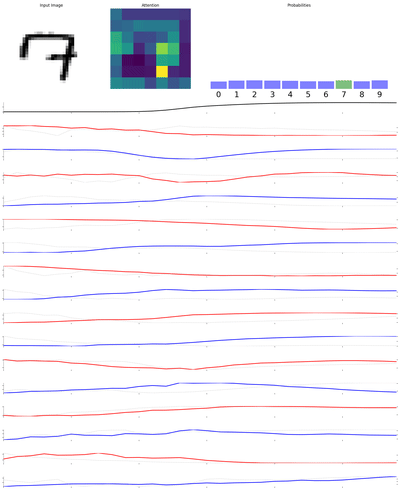